# Comparing different point interpolation approaches.

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

from metpy.mapping.map_functions import interpolate, remove_nan_observations, remove_repeat_coordinates
from metpy.cbook import get_test_data

from matplotlib.colors import BoundaryNorm

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [2]:
def make_string_list(arr):
    return [s.decode('ascii') for s in arr]


def station_test_data(variable_names, proj_from=None, proj_to=None):

    f = get_test_data('station_data.txt')

    all_data = np.loadtxt(f, skiprows=1, delimiter=',',
                          usecols=(1, 2, 3, 4, 5, 6, 7, 17, 18, 19),
                          dtype=np.dtype([('stid', '3S'), ('lat', 'f'), ('lon', 'f'),
                                          ('slp', 'f'), ('air_temperature', 'f'),
                                          ('cloud_fraction', 'f'), ('dewpoint', 'f'),
                                          ('weather', '16S'),
                                          ('wind_dir', 'f'), ('wind_speed', 'f')]))

    all_stids = make_string_list(all_data['stid'])

    data = np.concatenate([all_data[all_stids.index(site)].reshape(1, ) for site in all_stids])

    value = data[variable_names]
    lon = data['lon']
    lat = data['lat']

    # lon = lon[~np.isnan(value)]
    # lat = lat[~np.isnan(value)]
    # value = value[~np.isnan(value)]

    if proj_from is not None and proj_to is not None:

        try:

            proj_points = proj_to.transform_points(proj_from, lon, lat)
            return proj_points[:, 0], proj_points[:, 1], value

        except Exception as e:

            print(e)
            return None

    return lon, lat, value


In [3]:
from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

levels = list(range(-20, 20, 1))
cmap = plt.get_cmap('jet')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

x, y, temp = station_test_data("air_temperature", from_proj, to_proj)

x, y, temp = remove_nan_observations(x, y, temp)
x, y, temp = remove_repeat_coordinates(x, y, temp)

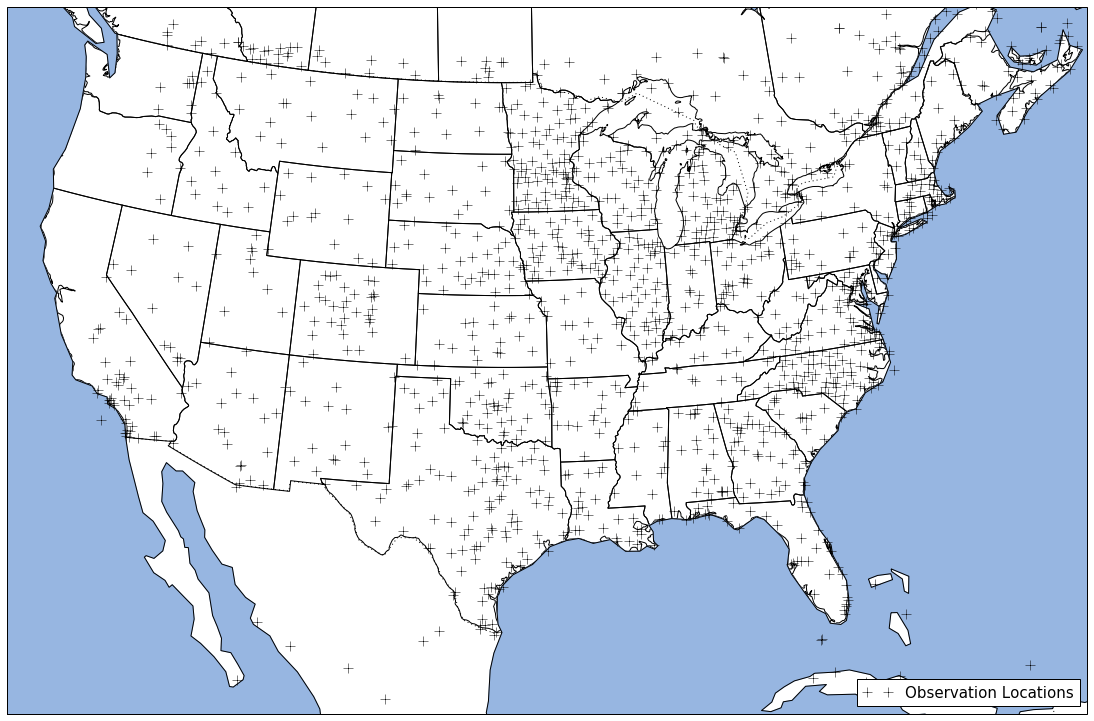

In [4]:
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

view.plot(x, y, "k+", markersize=10, label="Observation Locations")
plt.legend(loc=4, prop={'size':15})

# Nearest neighbor interpolation

http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.NearestNDInterpolator.html#scipy.interpolate.NearestNDInterpolator

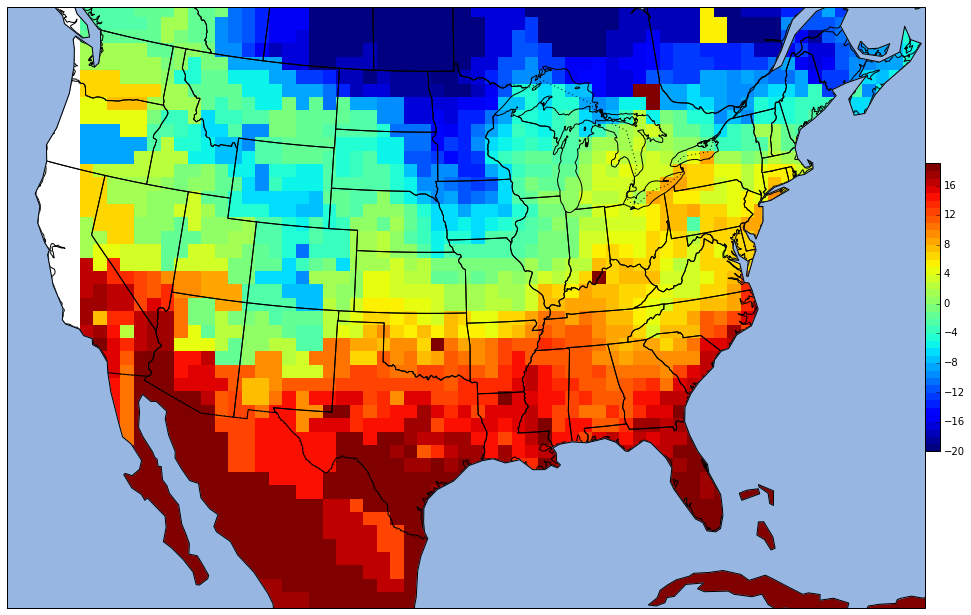

In [5]:
gx, gy, img = interpolate(x, y, temp, interp_type='nearest', hres=75000)

view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Linear interpolation

http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.LinearNDInterpolator.html#scipy.interpolate.LinearNDInterpolator

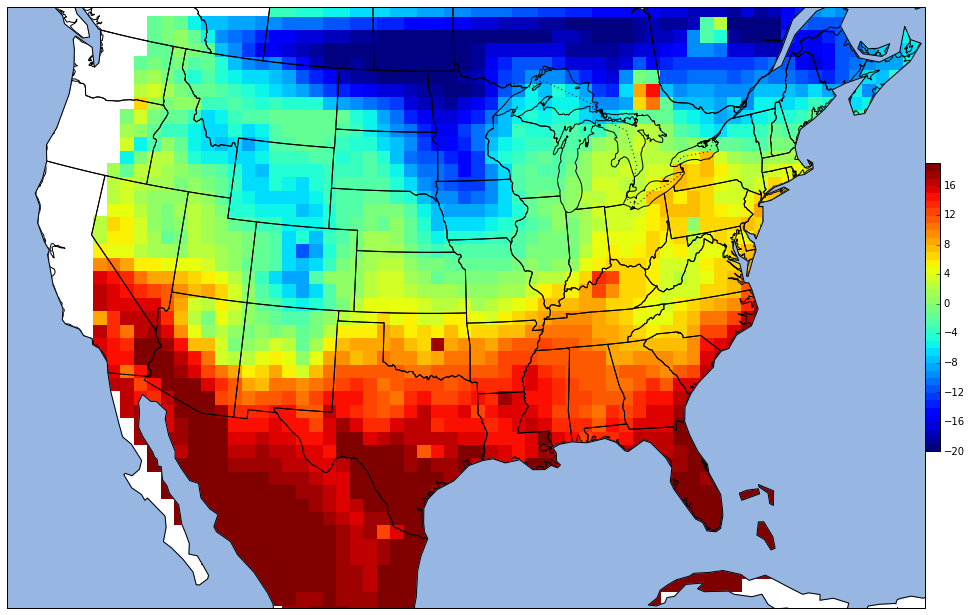

In [6]:
gx, gy, img = interpolate(x, y, temp, interp_type='linear', hres=75000)
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Cubic interpolation

http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.CloughTocher2DInterpolator.html#scipy.interpolate.CloughTocher2DInterpolator

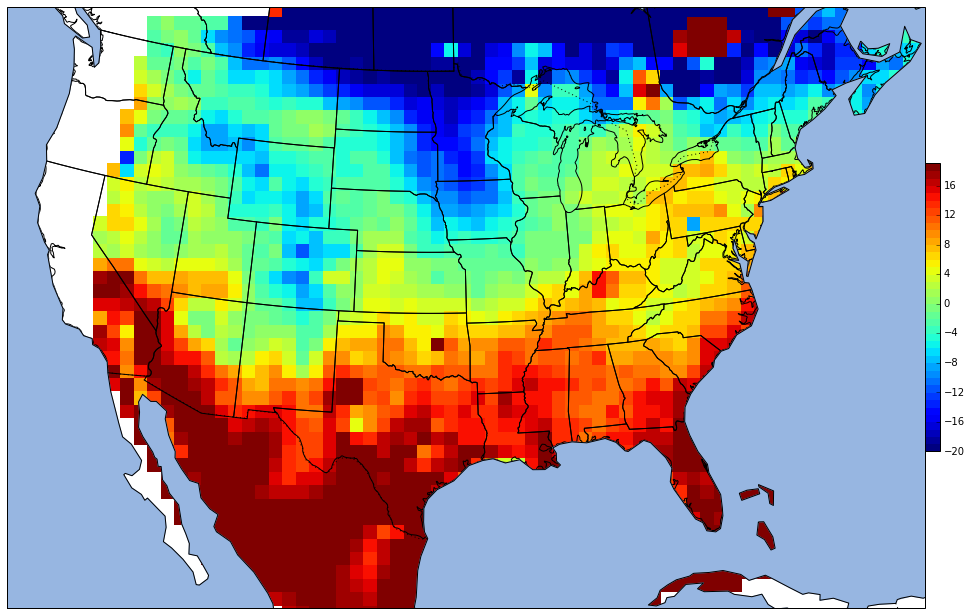

In [7]:
gx, gy, img = interpolate(x, y, temp, interp_type='cubic', hres=75000)
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Natural neighbor interpolation (MetPy implementation)

https://github.com/metpy/MetPy/files/138653/cwp-657.pdf

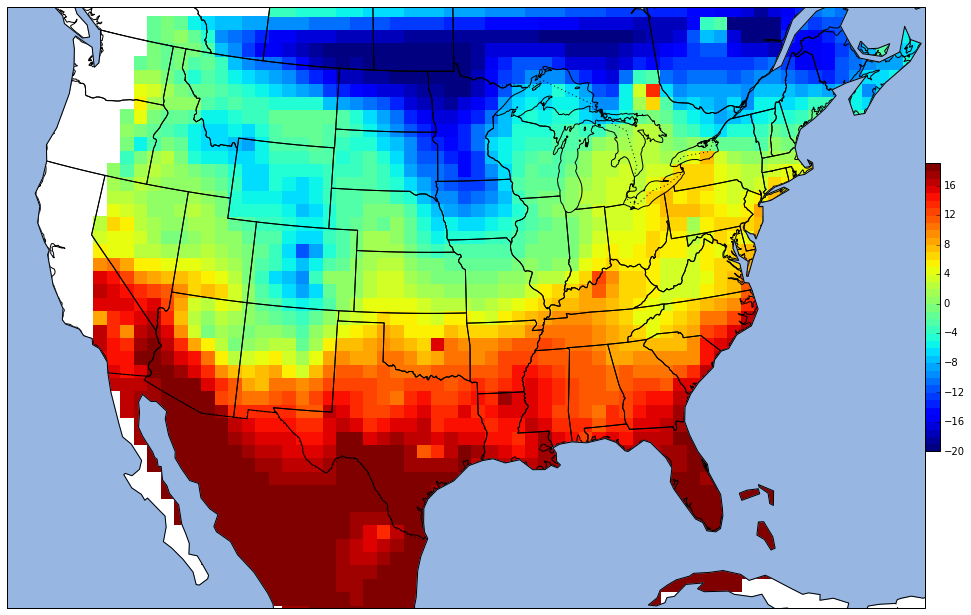

In [8]:
gx, gy, img = interpolate(x, y, temp, interp_type='natural_neighbor', hres=75000)
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Cressman interpolation

Default values:

search_radius = average observation spacing

min_neighbors = 3

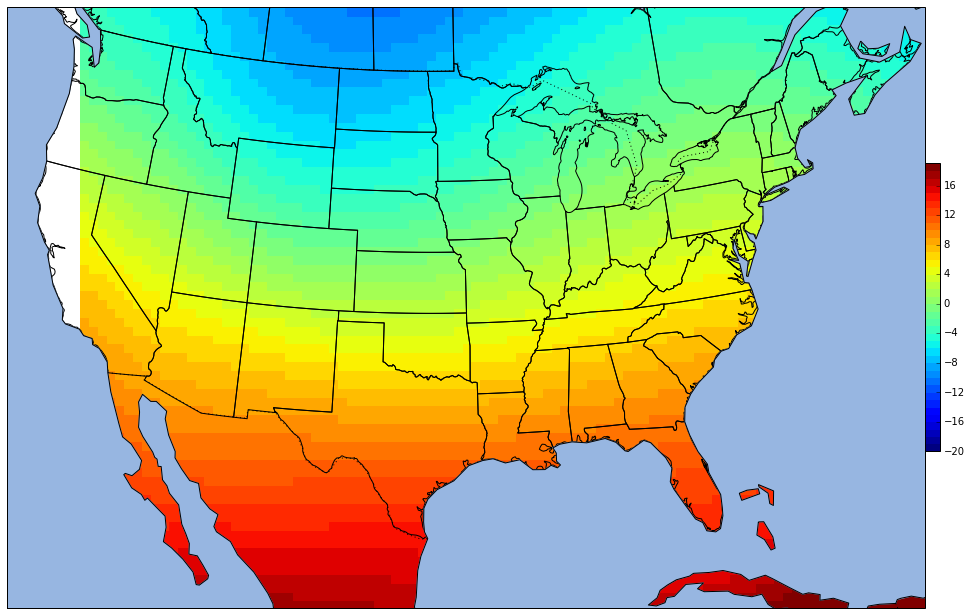

In [9]:
gx, gy, img = interpolate(x, y, temp, interp_type='cressman')
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Cressman interpolation

search_radius = 100 km

grid resolution = 25 km

min_neighbors = 1

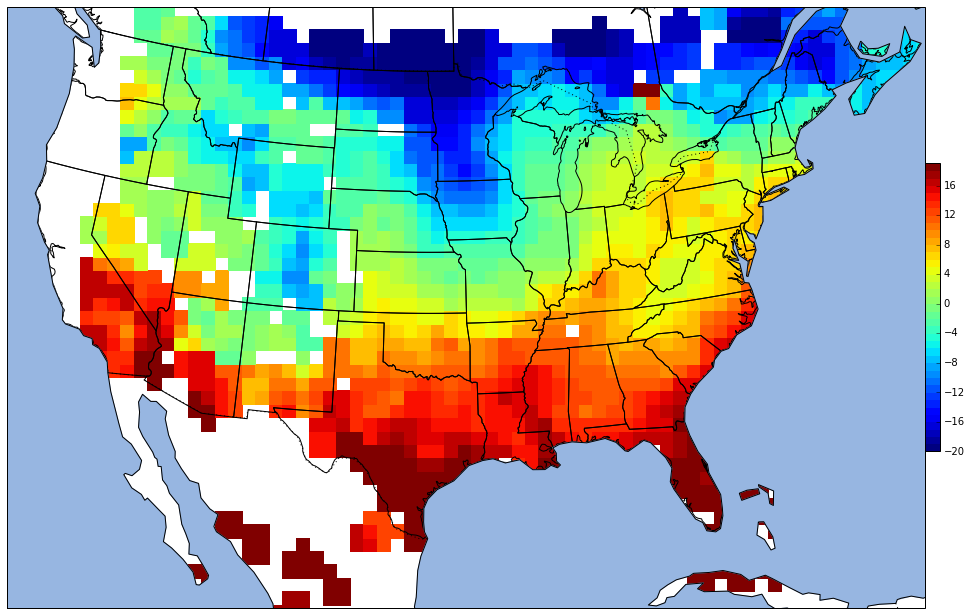

In [10]:
gx, gy, img = interpolate(x, y, temp, interp_type='cressman', minimum_neighbors=1, hres=75000, search_radius=100000)
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Barnes Interpolation

search_radius = 100km

min_neighbors = 3

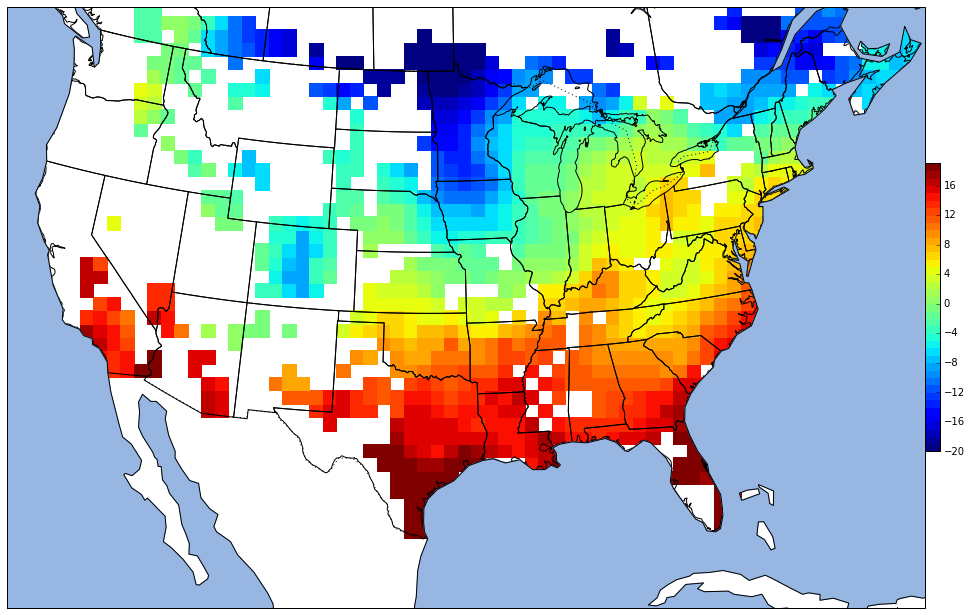

In [11]:
gx, gy, img1 = interpolate(x, y, temp, interp_type='barnes', hres=75000, search_radius=100000)
view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

mmb = view.pcolormesh(gx, gy, img1, cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)

# Radial basis functions interpolation

linear

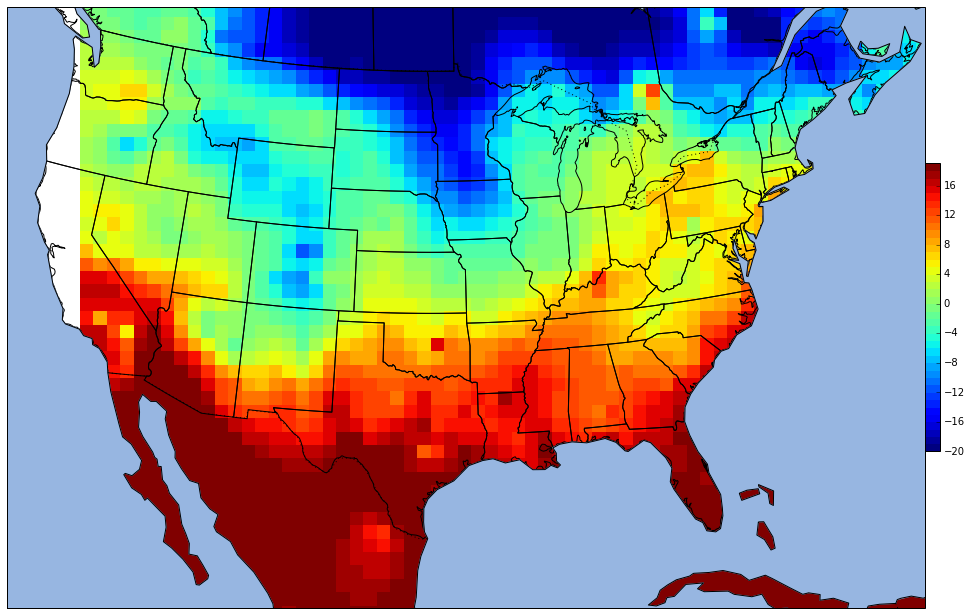

In [12]:
gx, gy, img = interpolate(x, y, temp, interp_type='rbf', hres=75000, rbf_func='linear', rbf_smooth=0)

view = plt.axes([0,0,1,1], projection=to_proj)
view.set_extent([-120, -70, 20, 50])
view.add_feature(cartopy.feature.NaturalEarthFeature(
                                category='cultural',
                                name='admin_1_states_provinces_lakes',
                                scale='50m',
                                facecolor='none'))
view.add_feature(cartopy.feature.OCEAN)
view.add_feature(cartopy.feature.COASTLINE)
view.add_feature(cartopy.feature.BORDERS, linestyle=':')

mmb = view.pcolormesh(gx, gy, img, cmap=cmap, norm=norm)
plt.colorbar(mmb, shrink=.4, pad=0, boundaries=levels)